In [1]:
import os
import time
import fiona
import datetime
import itertools

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import rasterio as rio
import geopandas as gp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

from pysheds.grid import Grid
from IPython.display import Image
from shapely.geometry import Point
from shapely.geometry import Polygon as shPolygon
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dateutil.relativedelta import relativedelta
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Delineate watersheds of the Sierra Nevada
* Use this knowtebook to demo DEM + flow routing algorithms + reservoir locations to delineate upstream catchments; key for reservoir operations, agricultural, and domestic water supply in California

### Get the elevation data and preproces
* Use Digital Elevation Models (DEMs) and flow routing algorithms
* Shuttle radar topography mission (SRTM) DEMS downloaded from: http://srtm.csi.cgiar.org/srtmdata/
* Merged by running from command line: 

`gdal_merge.py -o srtm_dem.tif srtm_12_04.tif srtm_12_05.tif srtm_13_04.tif srtm_13_05.tif srtm_13_06.tif`
    
* Clipped by running from command line:

`gdalwarp -cutline ../shape/cvws.shp -crop_to_cutline srtm_dem.tif hu6_srtm_dem.tif`

### Implement flow routing algorithms
* Use Pysheds package: https://github.com/mdbartos/pysheds (Thanks to @mdbartos for a very nifty package!) 
* (1) DEM --> (2) Flow Direction --> (3) Flow Accumulation --> (4) Adjust Pour Points --> (5) Watershed Delineation

### Load elevation data and plot using pysheds


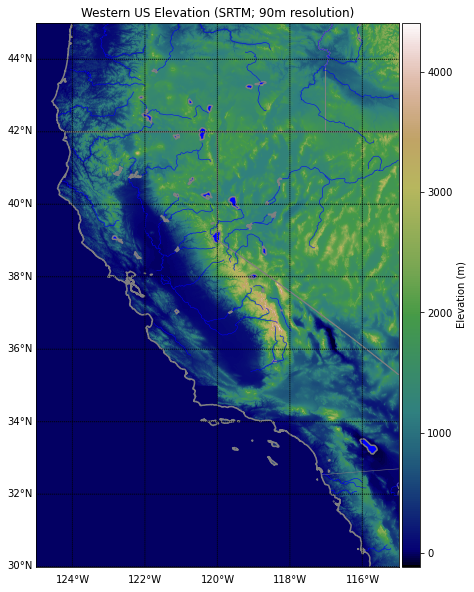

In [2]:
# Load
grid = Grid.from_raster('../rasters/srtm_dem.tif', data_name='dem')
gridarr = grid.dem.astype(float)
# gridarr[gridarr==0] = np.nan
src = rio.open('../rasters/srtm_dem.tif')

# get bbox of raster
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(8,10))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', linewidth=1.5, linestyle='solid',)
m.drawcountries(color='gray')
m.drawstates(color='gray', linewidth=1, linestyle='solid',)
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

im = m.imshow(np.flipud(gridarr), extent = grid.extent, cmap = "gist_earth")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='Elevation (m)')

ax1.set_title("Western US Elevation (SRTM; 90m resolution)")

plt.show()

### Clip to HUC4 and plot 

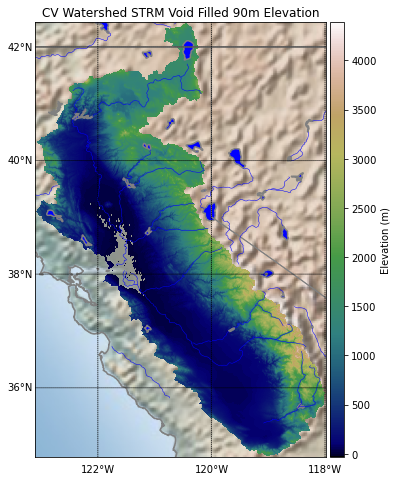

In [3]:
# Load
fn = '../rasters/hu6_srtm_dem.tif'
grid = Grid.from_raster(fn, data_name='dem')
gridarr = grid.dem.astype(float)
gridarr[gridarr==0] = np.nan
src = rio.open(fn)

# get bbox of raster
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,8))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', linewidth=1.5, linestyle='solid',)
m.drawcountries(color='gray')
m.drawstates(color='gray', linewidth=1, linestyle='solid',)
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

im = m.imshow(np.flipud(gridarr), extent = grid.extent, cmap = "gist_earth")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='Elevation (m)')

ax1.set_title("CV Watershed STRM Void Filled 90m Elevation")

plt.show()

### Compute the flow direction from the elevation data

* This computation takes a while (20 mins for 56m px on 4 core mac osx), even though the pysheds is very efficient
* `dirmap` variable corresponds to the the 8 possible directions neighboring a pixel:
* | N | NE | E | SE | S | SW | W | NW |

In [4]:
print("Number of cells = {}".format(str(grid.dem.shape[0]*grid.dem.shape[1])))

Number of cells = 56408180


In [5]:
# Chcek if we already have flowdir, if so, load, if not calc

if not os.path.exists("../rasters/flowdir_clip.tif"):
    
    print("Computing flow direction ")

    # Determine D8 flow directions from DEM
    grid = Grid.from_raster('../rasters/hu6_srtm_dem.tif', data_name='dem')

    # Fill depressions in DEM
    grid.fill_depressions('dem', out_name='flooded_dem')

    # Resolve flats in DEM
    grid.resolve_flats('flooded_dem', out_name='inflated_dem')

    # N    NE    E    SE    S    SW    W    NW
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

    # Compute flow directions
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    
    if not os.path.exists('../rasters/flowdir_clip.tif'):
        grid.to_raster('dir', '../rasters/flowdir.tif')
        clip_cmd = 'gdalwarp -cutline ../shape/cvws.shp -crop_to_cutline ../rasters/flowdir.tif ../rasters/flowdir_clip.tif'
        print(clip_cmd)
        os.system(clip_cmd)
        
    grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
    
else:
    grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')


### Compute flow dir in radians

* Alternatively, map the directions to radians by doing the following: 


In [6]:
# Flowdir to angle mapping
mapping = {
    64 : np.pi/2,
    128 : np.pi/4,
    1 : 0,
    2 : 7*np.pi/4,
    4 : 3*np.pi/2,
    8 : 5*np.pi/4,
    16 : np.pi,
    32 : 3*np.pi/4,
}

angle = (pd.Series(grid.view('dir', apply_mask=False, nodata=np.nan).ravel())
            .map(mapping).values.reshape(grid.shape))


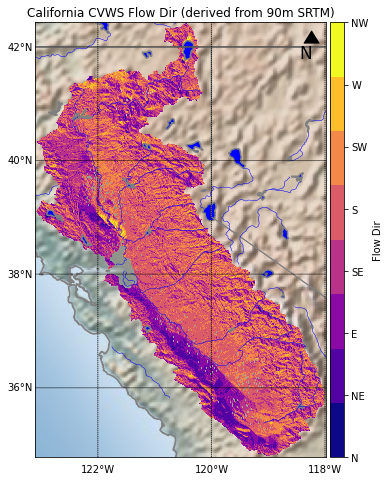

In [7]:
# Load
fn = '../rasters/hu6_srtm_dem.tif'
src = rio.open(fn)

# get bbox of raster
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,8))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', linewidth=1.5, linestyle='solid',)
m.drawcountries(color='gray')
m.drawstates(color='gray', linewidth=1, linestyle='solid',)
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

im = m.imshow(np.flipud(angle), extent = grid.extent, cmap = plt.cm.get_cmap('plasma', 8))

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(mappable=im, cax=cax, label='Flow Dir')

# Set the ticks 
cbar.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4])
cbar.set_ticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"])

# Add N arrow 
ax1.annotate('N', xy=(0.95, 0.98), xytext=(0.95, 0.95),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=17,
            xycoords=ax1.transAxes)

#tile 
ax1.set_title("California CVWS Flow Dir (derived from 90m SRTM)")

plt.show()

* The nans you see here are pixels that do not "flow" to others. I.e. they are sink (I think) 

### Compute flow accumulation

* Flow accumulation is the number of upstream pixels that drain to any given pixel
* We don't actually need this to delineate watersheds, however, it is very useful to position pour points correctly to obtain the correct watershed when doing the delineation. 


In [8]:
# Make a mask for the cv watershed
amask = angle[angle!=np.nan].reshape(angle.shape)
amask[np.isfinite(amask)]=1

# Specify dirmap as above
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Compute flow acc 
grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
grid.accumulation('dir', dirmap=dirmap, out_name='acc')


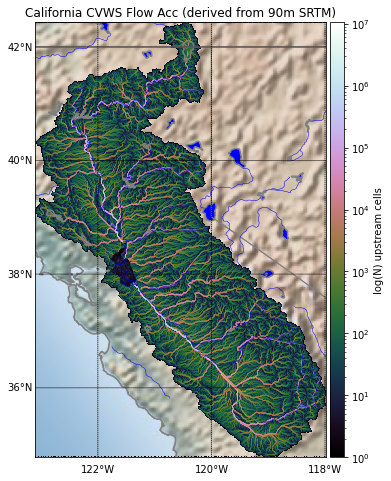

In [9]:
# Load
fn = '../rasters/hu6_srtm_dem.tif'
src = rio.open(fn)

# get bbox of raster
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,8))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', linewidth=1.5, linestyle='solid',)
m.drawcountries(color='gray')
m.drawstates(color='gray', linewidth=1, linestyle='solid',)
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

im = m.imshow(np.flipud(grid.view('acc', apply_mask=False)), cmap='cubehelix', extent = grid.extent,
                   norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()), zorder=1)

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='log(N) upstream cells')

ax1.set_title("California CVWS Flow Acc (derived from 90m SRTM)")

plt.show()



### Get the watershed outlets from the reservoirs and gauges shapefile 

The watershed outlets for subwatersheds of the sierra are listed in: Null, S. E., Viers, J. H., & Mount, J. F. (2010). Hydrologic response and watershed sensitivity to climate warming in California's Sierra Nevada. PLoS One, 5(4), e9932.


After some research, in contrast with Null et al., (2010), we want to use Isabella Lake instead of the Rio Bravo River for Kern, since reservoir operations affect the downstream gauge. Other than that, these are mostly the same 

In [10]:
# if reservoirs shapefile doesnt exist, read the reservoirs csv, make shapefile/gdf
if not os.path.exists("../shape/cdec_res.shp"):
    resdf = pd.read_csv("../data/CDEC_Stations.csv", sep = '\t')
    resdf_geometry = [Point(xy) for xy in zip(resdf.Longitude, resdf.Latitude)]
    resdf = resdf.drop(['Longitude', 'Latitude'], axis=1)
    gdf = gp.GeoDataFrame(resdf, crs="EPSG:4326", geometry=resdf_geometry)
    gdf.to_file("../shape/cdec_res.shp")
else:
    gdf = gp.read_file("../shape/cdec_res.shp")

In [11]:
# Check if the processed file already exists 
if not os.path.exists("../shape/term_res.shp"):
    reservoirs = gp.read_file("../shape/cdec_res.shp")
    # Filter the reservoirs based string matching this list:
    keep_ids = ['TRM', 'ENG','MIL','FOL','DNP','CFW','ORO','NML','NHG','MCR','SCC','SHA','PNF','PAR','ISB']
    # Filter reservoirs for the outlets we want
    res_in = reservoirs[reservoirs['ID'].isin(keep_ids)]
    res_in.to_file("../shape/term_res.shp")


# KEY STEP: Snap the outlets to flowlines

* Unfortunately, there is a manual step that I don't know how to automate. Load the outlets shapefile and Flow Dir raster in Qgis. change the location of the outlet points to fall on the flow acc flowlines. This change is usually not more than a few pixels, sometimes 10-20 in flats. The reason this is necessary is the lack of lat/lon precision from USGS / DWR when reporting the coordinates of the reservors / stream gauges, and the SRTM grid. 
* This has been done, and the slightly modified file is called `../shape/term_res.shp`
* The next few blocks (1) get the coordinates of each point (2) calculate the upstream drainage area (3) Write the shapefiles to the `shape` directory

Processing BEAR RIVER AT CAMP FAR WEST DAM


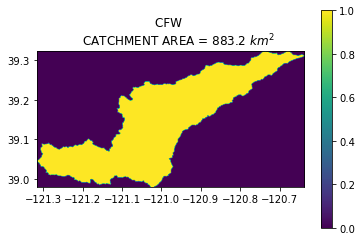

wrote ../shape/CFW.shp
Processing DON PEDRO RESERVOIR


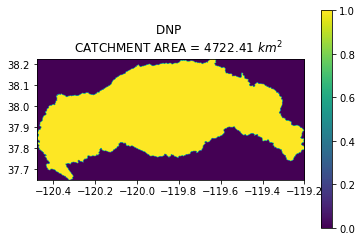

wrote ../shape/DNP.shp
Processing ENGLEBRIGHT (USACE)


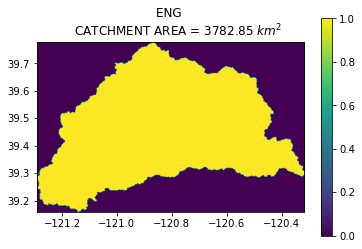

wrote ../shape/ENG.shp
Processing FOLSOM LAKE


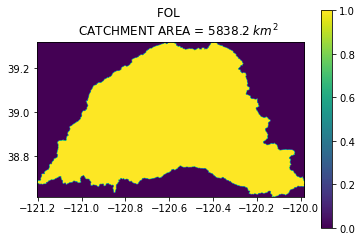

wrote ../shape/FOL.shp
Processing FRIANT DAM (MILLERTON)


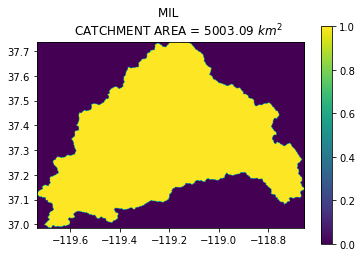

wrote ../shape/MIL.shp
Processing ISABELLA DAM


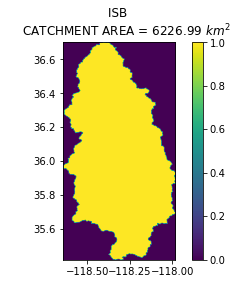

wrote ../shape/ISB.shp
Processing LAKE MCCLURE


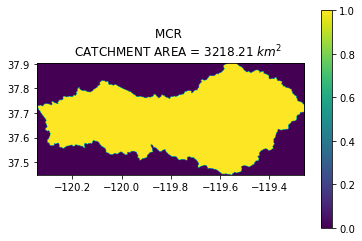

wrote ../shape/MCR.shp
Processing NEW HOGAN LAKE


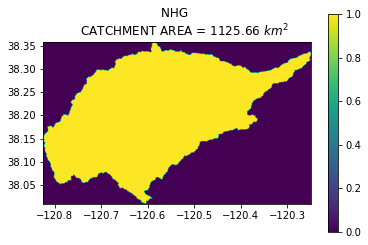

wrote ../shape/NHG.shp
Processing NEW MELONES RESERVOIR


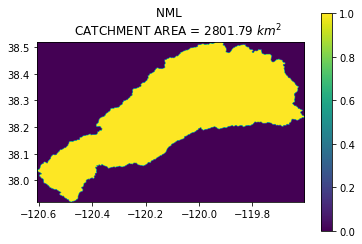

wrote ../shape/NML.shp
Processing OROVILLE DAM


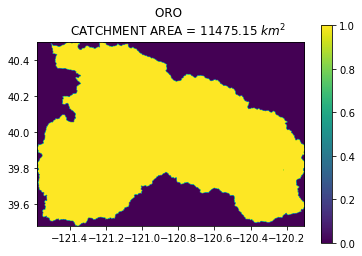

wrote ../shape/ORO.shp
Processing PARDEE


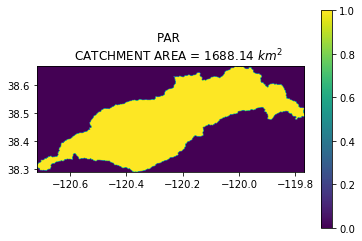

wrote ../shape/PAR.shp
Processing PINE FLAT DAM


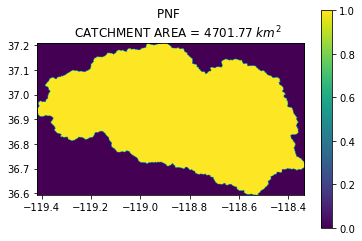

wrote ../shape/PNF.shp
Processing SHASTA DAM (USBR)


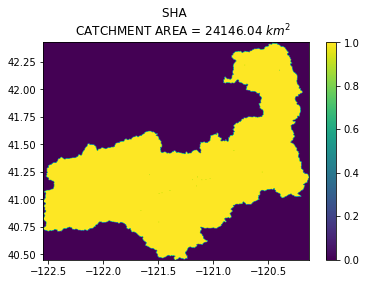

wrote ../shape/SHA.shp
Processing SUCCESS DAM


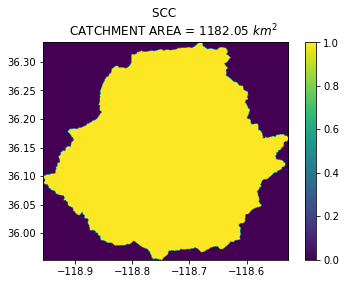

wrote ../shape/SCC.shp
Processing TERMINUS DAM


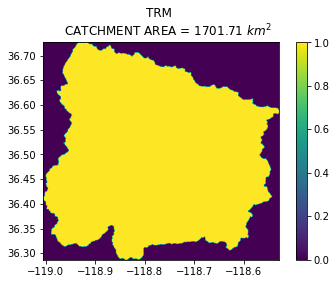

wrote ../shape/TRM.shp


<Figure size 432x288 with 0 Axes>

In [12]:
# Read the file we wrote and edited 
outflows = gp.read_file("../shape/term_res.shp")

# Loop through the outlets, extract the upstream watershed from the flowdir raster from the x,y coordinates
for i in outflows[:].iterrows():
    
    # Reload the grid because we write in place each time
    grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
    # Select outlet from outflows df
    df = outflows.iloc[i[0]]
    x,y = df.geometry.x,df.geometry.y
    
    stname  = df['Station']
    riverB = df['River Basi']
    stid = df['ID']
    
    print("Processing "  + stname)
    # Delineate the catchment
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
    
    npix = np.nansum(grid.view('catch') > 0)
    wshed_area = 90*90*int(npix)*1e-6 # calc approximate wshed area for 90m pixels --> sq km

    # Plot the result
    grid.clip_to('catch')
    plt.imshow(grid.view('catch') > 0, extent = grid.extent)  
    plt.title('''{} 
    CATCHMENT AREA = {} $km^2$'''
    .format(stid,str(round(wshed_area,2))))
    
    plt.colorbar()
    plt.show()
    plt.tight_layout()
    
    # Extract as shapefile and write result
    shapes = grid.polygonize()

    shlist = list(shapes)
    for shp in shlist:
        tdf = pd.DataFrame(shp[0])
        if not len((tdf['coordinates'].values)[0]) < 10: # Filter out super small polys (artifacts)
            ptdf = pd.DataFrame(tdf['coordinates'].values[0], columns = ['lon', 'lat'])
            polygon_geom = shPolygon(zip(list(ptdf.lon.values), list(ptdf.lat.values)))
            ptdf2 = ptdf.drop(['lon', 'lat'], axis=1)
            gdf = gp.GeoDataFrame(pd.DataFrame([]), crs="EPSG:4326", geometry= [polygon_geom])
            gdf['outlet_id'] = stname
            gdf['area_km2'] = wshed_area
            gdf['catch_name'] = riverB
            gdf['stid'] = stid
        
    gdf.to_file("../shape/{}.shp".format(stid))
    print("wrote ../shape/{}.shp".format(stid))

    print("=======" * 7)
    

In [13]:
# Load the files we just wrote, and plot to sanity check

In [14]:
shpdir = "../shape"
catchments = [os.path.join(shpdir,x) for x in os.listdir(shpdir) if x[:-4] in list(outflows['ID']) if x.endswith(".shp")]
gdfs = [gp.read_file(c) for c in catchments]

scatch = pd.concat(gdfs)
scatch = scatch[~scatch['outlet_id'].isna()] # Drop any small poly artifacts 
# scatch.plot()

# Put it all together and plot most of what we just did 

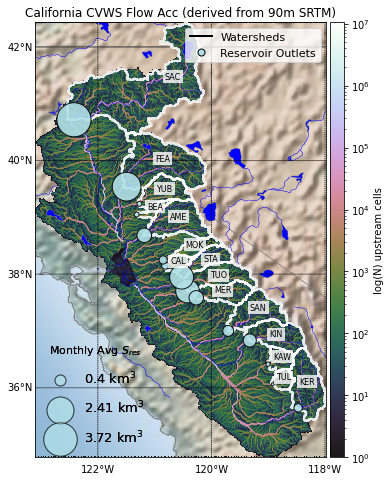

In [15]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)

# Calc flow acc
grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
grid.accumulation('dir', dirmap=dirmap, out_name='acc')

# Get the bbox using rasterio 
src = rio.open("../rasters/flowacc_clip.tif")

# Get precomputed reservoir stats
all_reservoirs = gp.read_file('/Users/aakashahamed/Desktop/RS_GW/shape/reservoirs_grace.shp')
reservoirs = all_reservoirs[all_reservoirs['ID'].isin(list(scatch['stid']))]

rp1 = np.percentile(reservoirs['Smean'], 50)
rp2 = np.percentile(reservoirs['Smean'], 90)
rp3 = np.percentile(reservoirs['Smean'], 99)

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,8))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(scatch, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 0.9, sizecol= reservoirs["Smean"]*300,  color= 'powderblue', edgecolor = 'black')

# label catchments
c = scatch.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    ax1.text(row.coords[0], row.coords[1], s=row['catch_name'].split()[0][:3], horizontalalignment='center', size =8,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# Plot flowdir array 
im = m.imshow(np.flipud(grid.view('acc')), cmap='cubehelix', extent = grid.extent,
                   norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()), zorder=1, alpha = 0.9)
ax1.set_title("California CVWS Flow Acc (derived from 90m SRTM)")
ax1.axes.xaxis.set_ticks([])
ax1.axes.yaxis.set_ticks([])

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='log(N) upstream cells')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="powderblue"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Reservoir Outlets'],
                    loc = "upper right",
                    prop={'size':11})

ax1.add_artist(leg1)

# Make second legend for reservoir storage
h = [plt.scatter([],[], color="powderblue",edgecolor = 'black',
                 alpha=0.5, s=rp*300,label=str(round(rp,2)) + ' km$^3$') 
     for rp in [rp1, rp2, rp3]]

leg2 = ax1.legend(handles=h, scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',
            prop={'size':13})
leg2.set_title("Monthly Avg $S_{res}$", prop = {'size':11})

ax1.add_artist(leg2)

plt.show()

In [16]:
# Write the merged shapefile 
scatch.to_file("../shape/sierra_catchments.shp")

Processing TERMINUS DAM


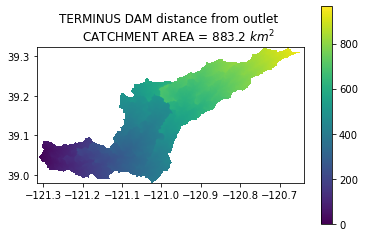

wrote ../rasters/BEAR RIVER AT CAMP FAR WEST DAM_dist.shp
Processing TERMINUS DAM


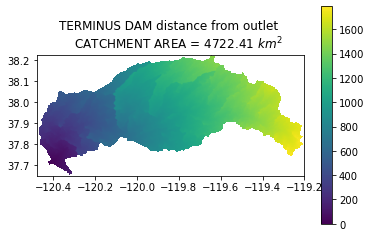

wrote ../rasters/DON PEDRO RESERVOIR_dist.shp
Processing TERMINUS DAM


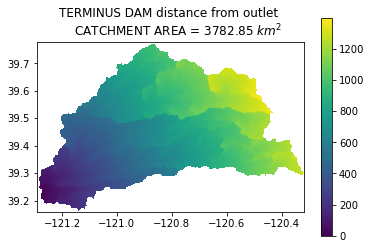

wrote ../rasters/ENGLEBRIGHT (USACE)_dist.shp
Processing TERMINUS DAM


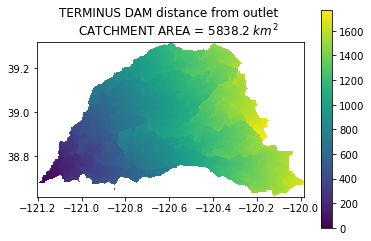

wrote ../rasters/FOLSOM LAKE_dist.shp
Processing TERMINUS DAM


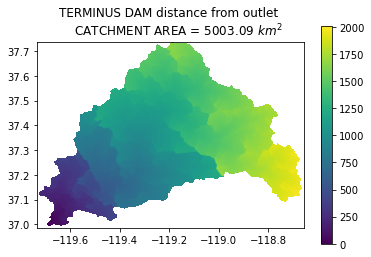

wrote ../rasters/FRIANT DAM (MILLERTON)_dist.shp
Processing TERMINUS DAM


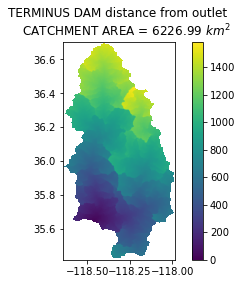

wrote ../rasters/ISABELLA DAM_dist.shp
Processing TERMINUS DAM


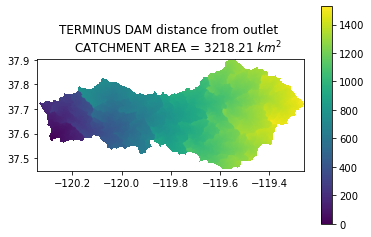

wrote ../rasters/LAKE MCCLURE_dist.shp
Processing TERMINUS DAM


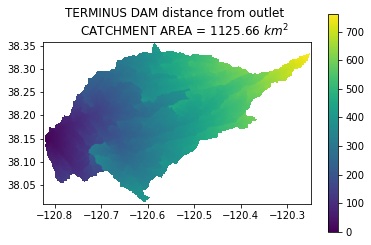

wrote ../rasters/NEW HOGAN LAKE_dist.shp
Processing TERMINUS DAM


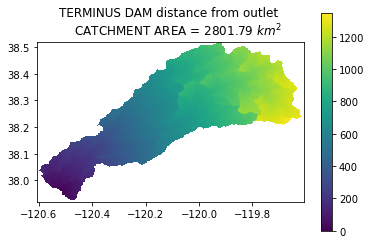

wrote ../rasters/NEW MELONES RESERVOIR_dist.shp
Processing TERMINUS DAM


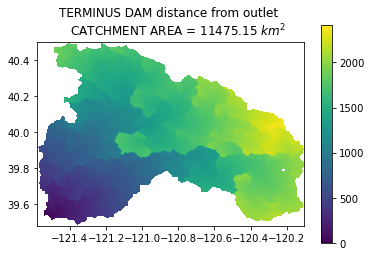

wrote ../rasters/OROVILLE DAM_dist.shp
Processing TERMINUS DAM


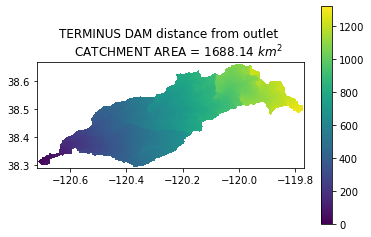

wrote ../rasters/PARDEE_dist.shp
Processing TERMINUS DAM


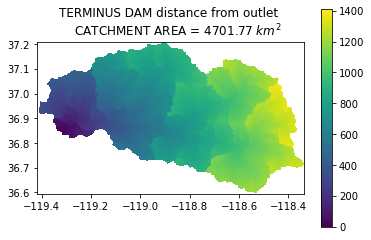

wrote ../rasters/PINE FLAT DAM_dist.shp
Processing TERMINUS DAM


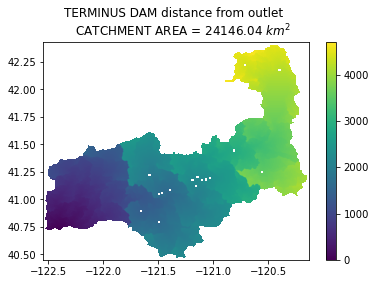

wrote ../rasters/SHASTA DAM (USBR)_dist.shp
Processing TERMINUS DAM


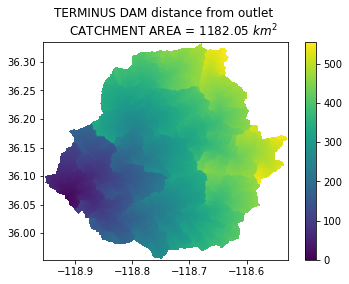

wrote ../rasters/SUCCESS DAM_dist.shp
Processing TERMINUS DAM


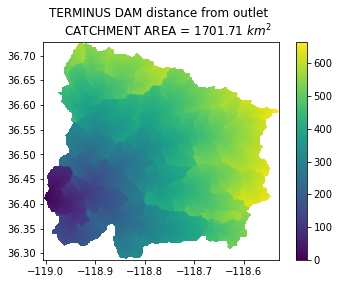

wrote ../rasters/TERMINUS DAM_dist.shp


<Figure size 432x288 with 0 Axes>

In [17]:
# Calc the distance from outlet of each pixel 
# TODO: Parallelize and run over a weekend - This takes FOREVER to run

for i in outflows[:].iterrows():
    
    # Reload the grid because we write in place each time
    grid = Grid.from_raster('../rasters/flowdir_clip.tif', data_name='dir')
    # Select outlet from outflows df
    df = outflows.iloc[i[0]]
    x,y = df.geometry.x,df.geometry.y
    
    # Get the site id
    if not df.Station is None:
        stid = df.Station
    else:
        stid  = df.ID
    
    print("Processing "  + stname)    # Delineate the catchment
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
    
    grid.flow_distance(x, y, 'dir', xytype='label', dirmap=dirmap,
                   out_name='dist', nodata_out=np.nan, method='shortest')
    
    # save
    outdir = "../rasters/flow_dist"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    grid.to_raster('dist', '../rasters/flow_dist/s{}_dist.tif'.format(stid))
    
    npix = np.nansum(grid.view('catch') > 0)
    wshed_area = 90*90*int(npix)*1e-6

    # Plot the result
    grid.clip_to('catch')
    plt.imshow(grid.view('dist'), extent = grid.extent)  
    plt.title('''{} distance from outlet 
    CATCHMENT AREA = {} $km^2$'''
    .format(stname,str(round(wshed_area,2))))
    
    plt.colorbar()
    plt.show()
    plt.tight_layout()
    
    print("wrote ../rasters/{}_dist.shp".format(stid))    
    print("=======" * 7)
    

In [19]:
outflows.ID

0     CFW
1     DNP
2     ENG
3     FOL
4     MIL
5     ISB
6     MCR
7     NHG
8     NML
9     ORO
10    PAR
11    PNF
12    SHA
13    SCC
14    TRM
Name: ID, dtype: object